### CAM, Grad-CAM 용 모델 준비하기 (1) 데이터셋 준비하기
CAM은 클래스에 대한 활성화 정도를 나타낸 지도이다. 따라서 기본적으로 우리의 모델은 분류(classification)를 수행하는 모델이어야 한다. 하지만 모델의 성능을 테스트하기 위해서 일단 학습 데이터셋으로 바운딩박스 정보를 가지고 있는 데이터셋을 이용하도록 하겠다.  
  
- <a href="https://www.tensorflow.org/datasets/catalog/cars196">Cars196 in Tensorflow Datasets</a>  
  
`cars196` 데이터셋은 8,144장의 학습용 데이터셋과 8,041장의 평가용 데이터셋으로 구성되어 있다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

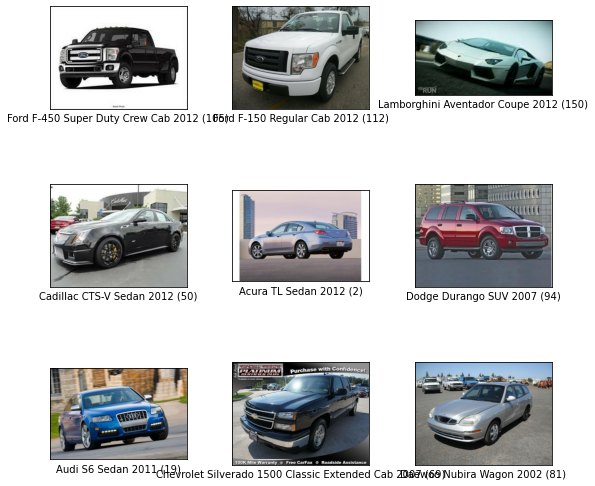

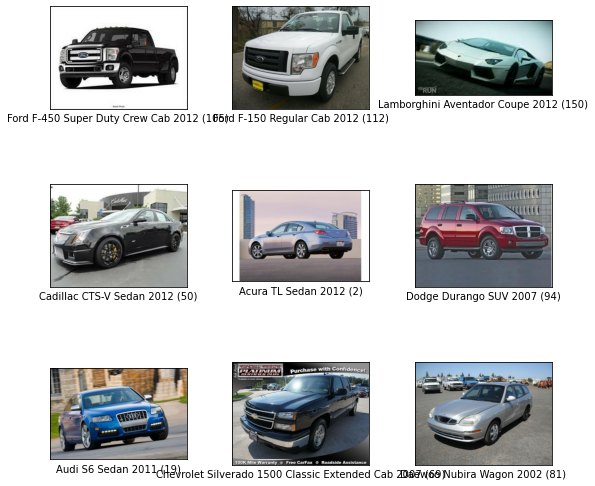

In [4]:
tfds.show_examples(ds_train, ds_info)

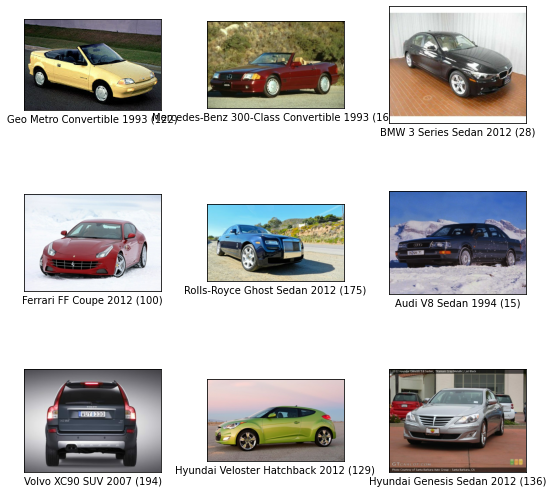

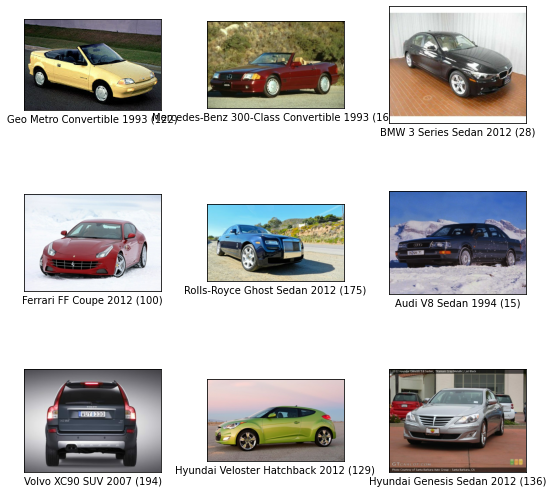

In [5]:
tfds.show_examples(ds_test, ds_info)

### CAM, Grad-CAM 용 모델 준비하기 (2) 물체의 위치정보

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

### CAM, Grad-CAM 용 모델 준비하기 (3) CAM을 위한 모델 만들기
  
`resnet50` 기반을 활용하고 이후 pooling layer뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들어 보자. 참고로 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 Fully connected layer이다.  
  
#### 구현해보기
`resnet50` 뒤에 필요한 레이어을 붙여 CAM을 구하기 위한 기본 모델을 완성해보자.

In [9]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',  # 여기에 GAP가 붙은 것
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [10]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### CAM, Grad-CAM 용 모델 준비하기 (4) CAM 모델 학습하기
  
`input`에 이전과 다르게 `bbox`정보가 포함되어 있지만, CAM 모델에서는 필요가 없으니, `normalize_and_resize_img`에서 제외해 주었다. CAM 모델은 Object detection이나 segmantaion에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고, weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다.

In [12]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [14]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [15]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 93s 183ms/step - loss: 4.1628 - accuracy: 0.1670 - val_loss: 5.4189 - val_accuracy: 0.0085
Epoch 2/15
509/509 [==============================] - 83s 163ms/step - loss: 1.5927 - accuracy: 0.6590 - val_loss: 1.8715 - val_accuracy: 0.5317
Epoch 3/15
509/509 [==============================] - 82s 162ms/step - loss: 0.5115 - accuracy: 0.9163 - val_loss: 1.3165 - val_accuracy: 0.6541
Epoch 4/15
509/509 [==============================] - 82s 161ms/step - loss: 0.1829 - accuracy: 0.9800 - val_loss: 1.1761 - val_accuracy: 0.6910
Epoch 5/15
509/509 [==============================] - 86s 170ms/step - loss: 0.0643 - accuracy: 0.9968 - val_loss: 1.0876 - val_accuracy: 0.7136
Epoch 6/15
509/509 [==============================] - 82s 160ms/step - loss: 0.0351 - accuracy: 0.9986 - val_loss: 1.0585 - val_accuracy: 0.7212
Epoch 7/15
509/509 [==============================] - 81s 159ms/step - loss: 0.0238 - accuracy: 0.9988 - val_loss: 1.0412 - val_ac

In [16]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

### CAM
학습된 모델을 이용해서 CAM을 만들어보자. CAM은 데이터셋 전체가 아니라 한 장에 대해 확인을 해야하기 때문에 `get_one()`함수로 데이터셋에 한 장씩 뽑을 수 있도록 한다.

In [17]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

120


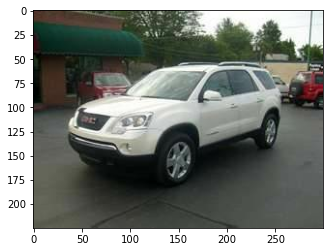

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [20]:
#CAM을 만들 모델을 불러오자
cam_model = tf.keras.models.load_model(cam_model_path)

#### CAM 생성 함수

In [21]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

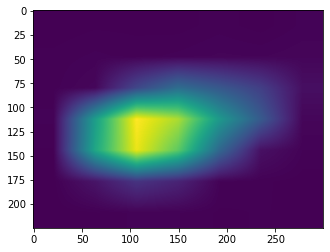

In [22]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [23]:
#원본이미지랑 합쳐보기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

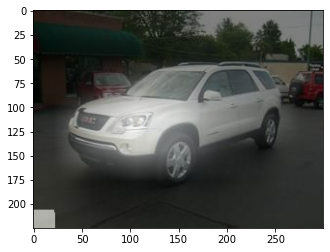

In [24]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### Grad-CAM

122


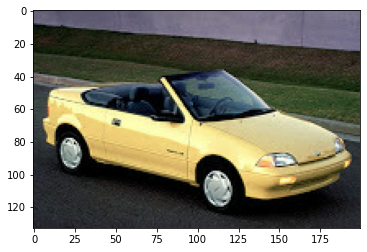

In [25]:
#새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [26]:
#원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val
#을 얻고 이를 weights로 활용한다.
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

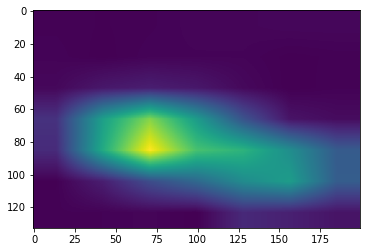

In [28]:
# 여러 레이어의 CAM 이미지를 뽑아서 직접 확인할 수 있다.
# 레이어의 이름은 model summary()에서 확인 가능하다.
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

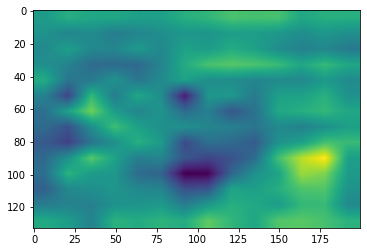

In [29]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

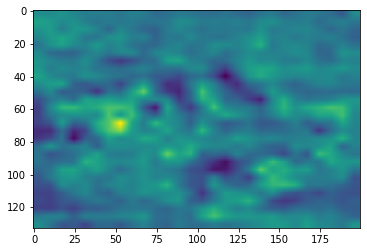

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

### Detection with CAM
#### 바운딩 박스
---

122


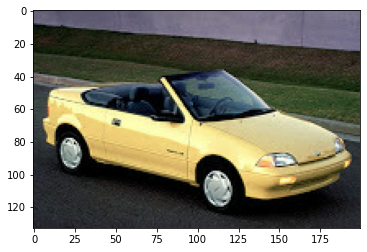

In [36]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

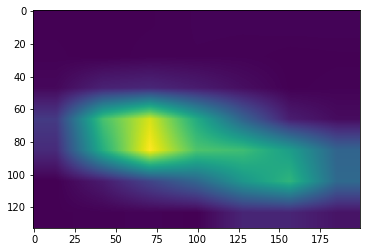

In [37]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [40]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh #바운딩박스 줄이기
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    #사각형 박스 찾기
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    
    #회전된 바운딩 박스를 얻는다.
    rotated_rect = cv2.minAreaRect(cnt)
    
    #꼭지점으로 바꾸어 준다.
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [41]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[194, 151],
       [-12, 101],
       [  8,  17],
       [214,  67]])

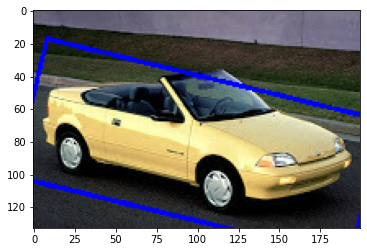

In [43]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

#### Intersection Over Union
---
위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 얻은 바운딩 박스가 있다. 그럼 정답 데이터인 바운딩 박스와 이를 비교 평가 할 때는 어떻게 할 수 있을까?

In [44]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [45]:
#rect를 minmax bbox 형태로 치환해 보자
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.12781954887218044, -0.06, 1.1353383458646618, 1.07]

In [46]:
item['bbox']

array([0.24812031, 0.03      , 0.9398496 , 0.985     ], dtype=float32)

In [47]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [48]:
get_iou(pred_bbox, item['bbox'])

0.5802403847617935